### Necessary libraries

In [48]:
import os
import sys
import time
import numpy
import warnings
import numpy as np
import pandas as pd
import seaborn as sb
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, train_test_split

### Paths

In [44]:
#REPOSITORY PATH OF PROJECT
(Tempo,_) = os.path.split(os.getcwd())
Tempo,_ = os.path.split(Tempo)
PATH_PROJECT,DEV = os.path.split(Tempo)
PATH_DEV = os.path.join(PATH_PROJECT,'Dev')
PATH_DATA = os.path.join(PATH_PROJECT,'Data')
PATH_DATA_IMAGES = os.path.join(PATH_DATA,'Data Images')
DATA_CBIRH_5_500 = os.path.join(PATH_DATA_IMAGES,'DATA_CBIRH_5_500')
PATH_DATA_CSV = os.path.join(os.path.join(PATH_DATA,'Data Descriptors'),'Data Feautures_5_500/All descriptors')
LIST_CLASS = os.listdir(PATH_DATA_CSV)
print(LIST_CLASS)

['DF_ALL_0.csv', 'DF_ALL_resise.csv', 'Model_RF.joblib', 'Testset.joblib', 'Trainset.joblib']


### Methods

In [49]:
# build path
def path_build(PATH_DATA_CSV):
    List_DF = []
    List_DF_without_header = []
    for i in os.listdir(PATH_DATA_CSV):
        if i.find('SIFT') !=-1 or i.find('FG') !=-1:
            List_DF_without_header.append((i,PATH_DATA_CSV+"/"+i))
        else:
            List_DF.append((i,PATH_DATA_CSV+"/"+i))
    return List_DF,List_DF_without_header

#split data to X,y
def split_data_without_head(path):
    DF = pd.read_csv(path)
    DF = DF.iloc[:,1::] 
    y =  y=DF[DF.columns[-1]] 
    del DF[DF.columns[-1]]
    X = DF
    return X,y

#plot confusion matrix
def plot_confusion_catrix(cm):
    
    sb.set(rc={'figure.figsize':(8,8)})
    sb.set(font_scale=1.4)#for label size
    ax = sb.heatmap(cm, annot=True, cmap ='Oranges', cbar=False)
    ax.set_title('Confusion Matrix with labels\n')
    ax.set_xlabel('\nPredicted Label')
    ax.set_ylabel('\nTrue Label ')
    _= ax.xaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
    _= ax.yaxis.set_ticklabels(['CAR','DOG','FRUIT','PERSON','CAT'])
    
#tuning hyperparameter of model   
def hyperparameter_tuning_MultiLayerPerceptron(xtrain,ytrain,xtest,ytest):
    start = time.time()
    MLP=MLPClassifier()   
    parameter_space = {
        'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [50, 100, 150,200,250,300],
        'activation': ['tanh', 'relu','logistic','identity'],
        'solver': ['sgd', 'adam','lbfgs'],
        'alpha': [0.0001, 0.09],
        'learning_rate': ['constant','adaptive','invscaling'],
    }
    kf = KFold(n_splits=5, random_state = 0, shuffle = True)
    randomizedsearch = RandomizedSearchCV(estimator=MLP, param_distributions=parameter_space,n_iter = 250,
                                          scoring='accuracy', cv= kf)
    randomizedsearch.fit(xtrain, ytrain)
    end = time.time()
    run_time = end - start
    print("[INFO] Applying took {:.2f} min".format(run_time/60))
    return randomizedsearch

#evaluate of result
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    accuracy = accuracy_score(test_labels, predictions)
    errors = 1-accuracy
    Confusion_Matrix = confusion_matrix(test_labels, predictions)
    print('[INFO] Model Performance')
    print('[INFO] Average Error: {:0.2f} %.'.format(np.mean(errors)))
    print('[INFO] Accuracy = {:0.2f}%.'.format(accuracy))
    print('[INFO] Classification_report :\n',classification_report(test_labels,predictions))
    print('[INFO] Confusion_Matrix : \n')
    plot_confusion_catrix(Confusion_Matrix)

def split_data(DF):
    y =  y=DF[DF.columns[-1]] 
    del DF[DF.columns[-1]]
    X = DF
    return X,y
def read_data(path):
    DF = pd.read_csv(path)
    DF = DF.iloc[:,1::]
    return DF

In [45]:
num_df = 0
List_DF,_ = path_build(PATH_DATA_CSV)
print("Data Features Study : ",List_DF[num_df][0])
X,y = split_data_without_head(List_DF[num_df][1])
print(X.shape)

Data Features Study :  DF_ALL_0.csv
(500, 511)


In [50]:
df = read_data(PATH_DATA_CSV+"\DF_ALL_0.csv")
Trainset = load(PATH_DATA_CSV+"\Trainset.joblib") 
Testset = load(PATH_DATA_CSV+"\Testset.joblib") 

In [51]:
X_train,y_train = split_data(Trainset)
X_test, y_test = split_data(Testset)
X,y = split_data(df)

In [52]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    randomizedsearch = hyperparameter_tuning_MultiLayerPerceptron(X_train,y_train, X_test, y_test)

[INFO] Applying took 21.03 min


[INFO] Model Performance
[INFO] Average Error: 0.66 %.
[INFO] Accuracy = 0.34%.
[INFO] Classification_report :
               precision    recall  f1-score   support

           0       0.60      0.68      0.64        22
           1       0.37      0.40      0.38        25
           2       0.24      0.15      0.19        26
           3       0.21      0.32      0.25        28
           4       0.38      0.21      0.27        24

    accuracy                           0.34       125
   macro avg       0.36      0.35      0.35       125
weighted avg       0.35      0.34      0.34       125

[INFO] Confusion_Matrix : 



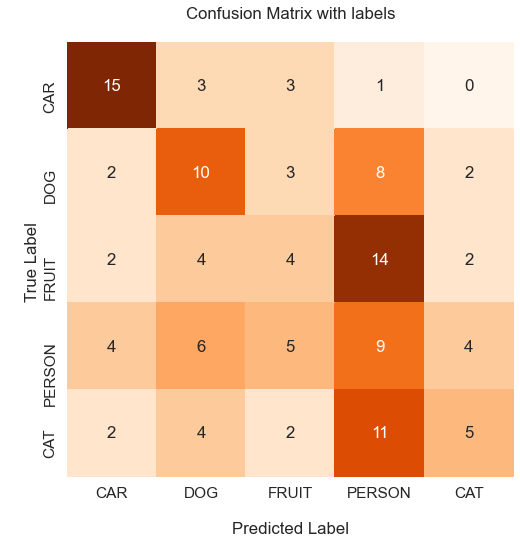

In [54]:
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
#Train data whith cross validation using Kfold = 5 and shuffle = True
#Using best estimator
clf = randomizedsearch.best_estimator_
#evaluate best estimator
evaluate(clf,X_test,y_test)

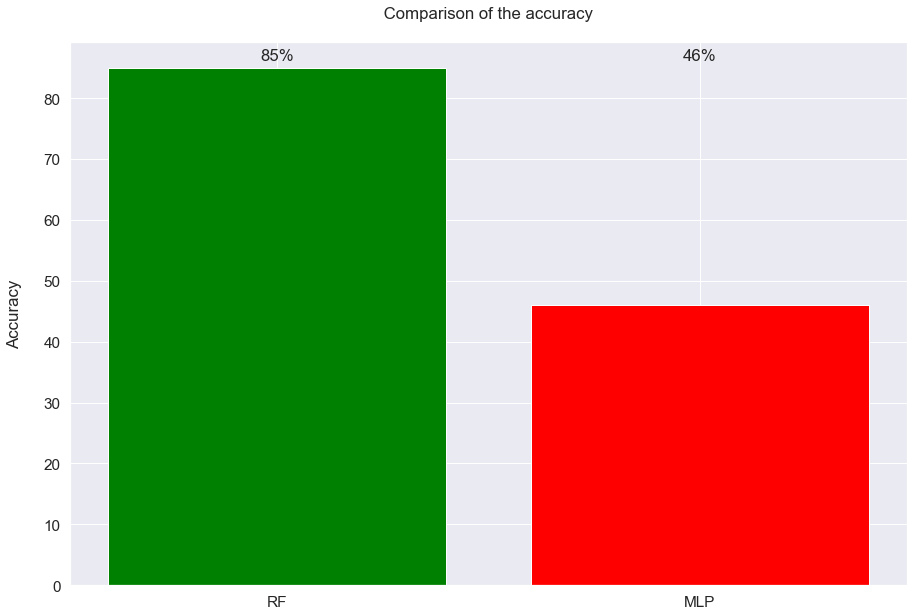

In [39]:
score_ = [85,46]
list_model = ["RF", "MLP"]
plt.figure(figsize=(15,10))
plt.bar(list_model,score_,color=[ 'green','red'])
for i,j in enumerate(score_) :
    plt.text(i,87,str(int(j))+'%', va = 'center', ha = 'center')
plt.xticks(list_model,rotation=0)
plt.ylabel("Accuracy\n")
plt.title(" Comparison of the accuracy \n")
plt.show()